In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import json
import os

from scipy.optimize import minimize
from scipy import constants

k_b = constants.physical_constants['Boltzmann constant in eV/K'][0]

from pymatgen.core.structure import Structure, Molecule
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer, PointGroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor

from ase.visualize import view

from utils import *
from random_structures import *
from QUBO_models import *

from braket.ahs.atom_arrangement import AtomArrangement, SiteType
from braket.ahs.driving_field import DrivingField
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation


def vview(structure):
    view(AseAtomsAdaptor().get_atoms(structure))

eV_to_rad_s = 1.519267447321156e15


## Small structure (4x3)

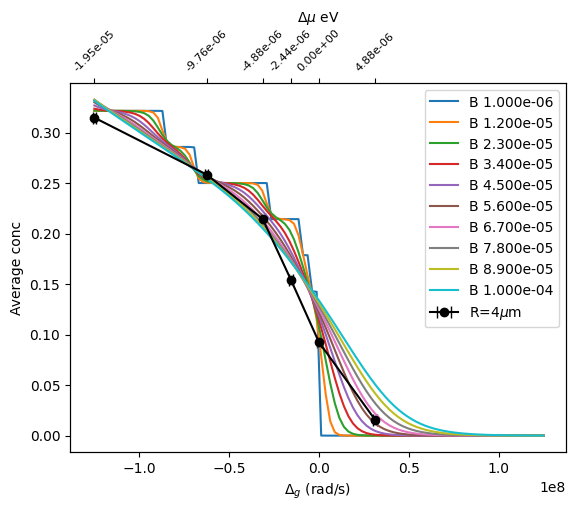

In [13]:
delta_g_all = ['-125000000','-62500000','-12500','-1250','0','1250','62500000','125000000']
delta_g_all = ['125000000','62500000','31250000','15625000','0','-31250000']

C6 = 5.42e-24
reg_coef = [0.00030122447260882713, 0.00020350836925458785]
V_2um = (C6/(4.01e-6**6))
V_qubo = reg_coef[1]*eV_to_rad_s
V_ratio = V_qubo/V_2um

delta_g_all_int = [-int(x) for x in delta_g_all]

folder = 'qpu_data/small_structure/4.01micrometers'
datasets = []

for delta_g in delta_g_all: 
    preseqs, postseqs = read_all_sequences_from_folder(os.path.join(folder, delta_g))
    
    preseqs = np.array(preseqs)
    postseqs = np.array(postseqs)
    # print(delta_g,preseqs)
    preseqs = stack_chunks_vertically(preseqs)
    postseqs = stack_chunks_vertically(postseqs)

    datasets.append((preseqs, postseqs, f"Δg = {delta_g}"))

hamming_average_all = []

for preseqs, postseqs, label in datasets:
    # Compute Hamming distances
    len_hamming, hamming_average, hamming_std, hamming_max, \
    hamming_min, hamming_unique, unique_index = get_hamming(preseqs, postseqs)
    
    hamming_average_all.append(hamming_average)

x = np.array(delta_g_all_int)  # wavelength in nm
y = np.array(hamming_average_all)/28  # fake spectrum

fig, ax = plt.subplots()
ax.errorbar(
    x, y,
    xerr=1e6,  # ±5e5 rad/s
    fmt='o-', capsize=4,
    label='R=4$\mu$m',color='k'
)
ax.set_xlabel('$\Delta_g$ (rad/s)')
ax.set_ylabel('Average conc')



with open("data/exhaustive_search/boltzmann_log/av_conc_4x3_4.01um_only.json", "r") as f:
    data = json.load(f)

# Plot each temperature's data
# plt.figure(figsize=(8, 6))

for T, values in data.items():
    # print(T)
    if float(T) < 100:
        x = np.array(values["Delta_mu"])*eV_to_rad_s
        y = np.array(values["avg_conc"])
    
        ax.plot(x, y,'-',label=f'B {float(T):.3e}')

# Top axis: energy in eV
ax_top = ax.twiny()

# Sync top axis with inverted bottom axis
ax_top.set_xlim(ax.get_xlim())

# Set custom ticks based on energy
Delta_g_qubo = 0 # TEMPORARY SET THIS TO 0. IT SHOULD BE THE VALUE OF Q_ii
Delta_g_hardware_ticks = copy.deepcopy(delta_g_all_int)
Delta_mu_ticks = [(-Delta_g_qubo + Delta_g_hardware * V_ratio) / eV_to_rad_s 
                  for Delta_g_hardware in np.array(delta_g_all_int)]
ax_top.set_xticks(Delta_g_hardware_ticks)
ax_top.set_xticklabels([f"{e:.2e}" for e in Delta_mu_ticks], fontsize=8,rotation=45)
ax_top.set_xlabel("$\Delta\mu$ eV")
ax.legend()

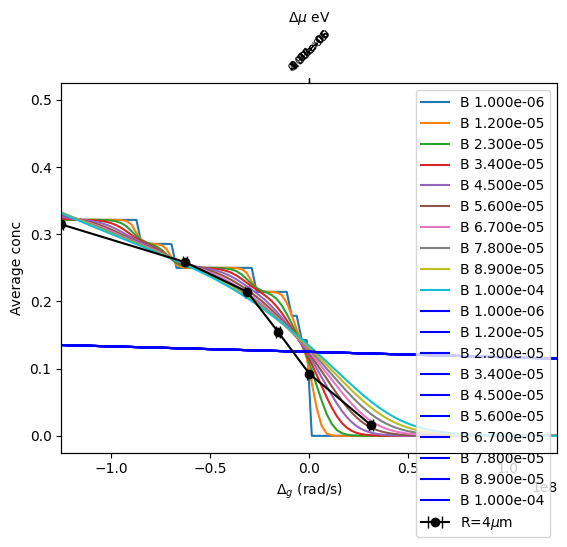

In [19]:
delta_g_all = ['-125000000','-62500000','-12500','-1250','0','1250','62500000','125000000']
delta_g_all = ['125000000','62500000','31250000','15625000','0','-31250000']

C6 = 5.42e-24
reg_coef = [0.00030122447260882713, 0.00020350836925458785]
V_2um = (C6/(4.01e-6**6))
V_qubo = reg_coef[1]*eV_to_rad_s
V_ratio = V_qubo/V_2um

delta_g_all_int = [-int(x) for x in delta_g_all]

folder = 'qpu_data/small_structure/4.01micrometers'
datasets = []

for delta_g in delta_g_all: 
    preseqs, postseqs = read_all_sequences_from_folder(os.path.join(folder, delta_g))
    
    preseqs = np.array(preseqs)
    postseqs = np.array(postseqs)
    # print(delta_g,preseqs)
    preseqs = stack_chunks_vertically(preseqs)
    postseqs = stack_chunks_vertically(postseqs)

    datasets.append((preseqs, postseqs, f"Δg = {delta_g}"))

hamming_average_all = []

for preseqs, postseqs, label in datasets:
    # Compute Hamming distances
    len_hamming, hamming_average, hamming_std, hamming_max, \
    hamming_min, hamming_unique, unique_index = get_hamming(preseqs, postseqs)
    
    hamming_average_all.append(hamming_average)

x = np.array(delta_g_all_int)  # wavelength in nm
y = np.array(hamming_average_all)/28  # fake spectrum

fig, ax = plt.subplots()
ax.errorbar(
    x, y,
    xerr=1e6,  # ±5e5 rad/s
    fmt='o-', capsize=4,
    label='R=4$\mu$m',color='k'
)
ax.set_xlabel('$\Delta_g$ (rad/s)')
ax.set_ylabel('Average conc')



with open("data/exhaustive_search/boltzmann_log/av_conc_4x3_4.01um_only.json", "r") as f:
    data = json.load(f)

# Plot each temperature's data
# plt.figure(figsize=(8, 6))

for T, values in data.items():
    # print(T)
    if float(T) < 100:
        x = np.array(values["Delta_mu"])*eV_to_rad_s
        y = np.array(values["avg_conc"])
    
        ax.plot(x, y,'-',label=f'B {float(T):.3e}')

with open("data/exhaustive_search/lr_coefficients/av_conc_4x3_lr_-4_4.json", "r") as f:
    data = json.load(f)
# with open("data/exhaustive_search/lr_coefficients/av_conc_4x3_lr_-6_6.json", "r") as f:
#     data = json.load(f)
# with open("data/exhaustive_search/lr_coefficients/av_conc_4x3_lr_-7_7.json", "r") as f:
#     data = json.load(f)

# Plot each temperature's data
# plt.figure(figsize=(8, 6))

for T, values in data.items():
    # print(T)
    if float(T) < 100:
        x = np.array(values["Delta_mu"])*eV_to_rad_s
        y = np.array(values["avg_conc"])
    
        ax.plot(x, y,'-',label=f'B {float(T):.3e}',color='b')

# Top axis: energy in eV
ax_top = ax.twiny()

# Sync top axis with inverted bottom axis
ax_top.set_xlim(ax.get_xlim())

# Set custom ticks based on energy
Delta_g_qubo = 0 # TEMPORARY SET THIS TO 0. IT SHOULD BE THE VALUE OF Q_ii
Delta_g_hardware_ticks = copy.deepcopy(delta_g_all_int)
Delta_mu_ticks = [(-Delta_g_qubo + Delta_g_hardware * V_ratio) / eV_to_rad_s 
                  for Delta_g_hardware in np.array(delta_g_all_int)]
ax_top.set_xticks(Delta_g_hardware_ticks)
ax_top.set_xticklabels([f"{e:.2e}" for e in Delta_mu_ticks], fontsize=8,rotation=45)
ax_top.set_xlabel("$\Delta\mu$ eV")
ax.set_xlim((-1.25e8,1.25e8))
ax.legend()

In [15]:
np.array(Delta_mu_ticks)

array([-1.95145812e-05, -9.75729062e-06, -4.87864531e-06, -2.43932266e-06,
        0.00000000e+00,  4.87864531e-06])

## Linear regression coefficients

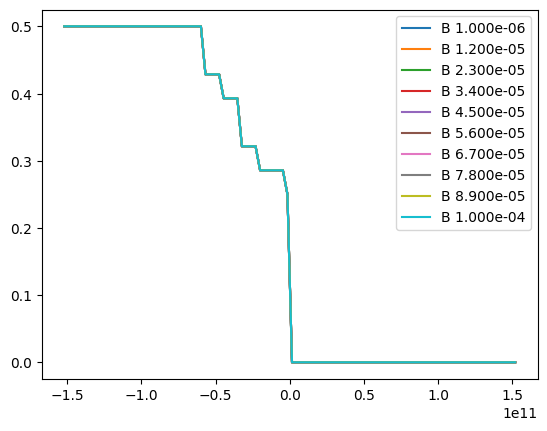

In [17]:
fig, ax = plt.subplots()

with open("data/exhaustive_search/lr_coefficients/av_conc_4x3_lr_-4_4.json", "r") as f:
    data = json.load(f)
# with open("data/exhaustive_search/lr_coefficients/av_conc_4x3_lr_-6_6.json", "r") as f:
#     data = json.load(f)
# with open("data/exhaustive_search/lr_coefficients/av_conc_4x3_lr_-7_7.json", "r") as f:
#     data = json.load(f)

# Plot each temperature's data
# plt.figure(figsize=(8, 6))

for T, values in data.items():
    # print(T)
    if float(T) < 100:
        x = np.array(values["Delta_mu"])*eV_to_rad_s
        y = np.array(values["avg_conc"])
    
        ax.plot(x, y,'-',label=f'B {float(T):.3e}')


ax.legend()

## Bose-Einstein

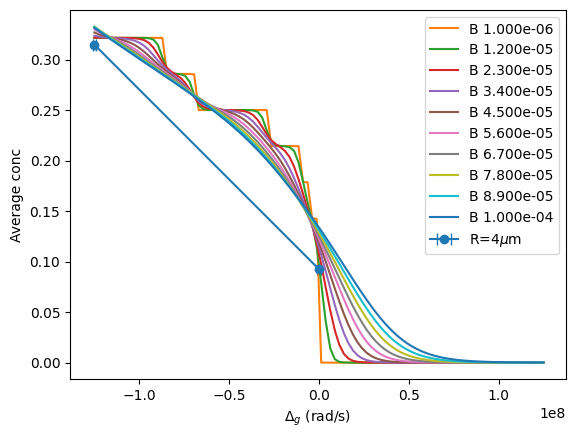

In [ ]:
delta_g_all = ['-125000000','-62500000','-12500','-1250','0','1250','62500000','125000000']
delta_g_all = ['125000000','62500000','31250000','0','-31250000']

delta_g_all_int = [-int(x) for x in delta_g_all]

folder = 'qpu_data/small_structure/4.01micrometers'
datasets = []

for delta_g in delta_g_all: 
    preseqs, postseqs = read_all_sequences_from_folder(os.path.join(folder, delta_g))
    
    preseqs = np.array(preseqs)
    postseqs = np.array(postseqs)

    preseqs = stack_chunks_vertically(preseqs)
    postseqs = stack_chunks_vertically(postseqs)

    datasets.append((preseqs, postseqs, f"Δg = {delta_g}"))

hamming_average_all = []

for preseqs, postseqs, label in datasets:
    # Compute Hamming distances
    len_hamming, hamming_average, hamming_std, hamming_max, \
    hamming_min, hamming_unique, unique_index = get_hamming(preseqs, postseqs)
    
    hamming_average_all.append(hamming_average)

x = np.array(delta_g_all_int)  # wavelength in nm
y = np.array(hamming_average_all)/28  # fake spectrum

fig, ax = plt.subplots()
ax.errorbar(
    x, y,
    xerr=1e6,  # ±5e5 rad/s
    fmt='o-', capsize=4,
    label='R=4$\mu$m'
)
ax.set_xlabel('$\Delta_g$ (rad/s)')
ax.set_ylabel('Average conc')



with open("data/exhaustive_search/boltzmann_log/av_conc_4x3_4.01um_only.json", "r") as f:
    data = json.load(f)

# Plot each temperature's data
# plt.figure(figsize=(8, 6))

for T, values in data.items():
    x = np.array(values["Delta_mu"])*eV_to_rad_s
    y = np.array(values["avg_conc"])
   
    ax.plot(x, y,'-',label=f'B {float(T):.3e}')


ax.legend()

In [92]:
2**32

4294967296

### 4 micrometer

In [70]:
folder = '/Users/brunocamino/Desktop/UCL/rydberg_atoms/qpu_data/4micrometers/'
datasets = []
delta_g_all = ['125000000','62500000','31250000','0','-31250000']
delta_g_all_int = [-int(x) for x in delta_g_all]

for delta_g in delta_g_all: 
    preseqs, postseqs = read_all_sequences_from_folder(os.path.join(folder, delta_g))
    datasets.append((preseqs, postseqs, f"Δg = {delta_g}"))

In [71]:
hamming_average_all = []
num_sites = 78
for idx, (preseqs, postseqs, label) in enumerate(datasets):


    # Compute Hamming distances
    len_hamming, hamming_average, hamming_std, hamming_max, \
    hamming_min, hamming_unique, unique_index = get_hamming(preseqs, postseqs)
    
    hamming_average_all.append(hamming_average)

hamming_average_all = np.array(hamming_average_all)
hamming_average_all_norm = hamming_average_all/num_sites
hamming_average_all_norm_4 = copy.deepcopy(hamming_average_all_norm)
delta_g_all_int_4 = copy.deepcopy(delta_g_all_int)

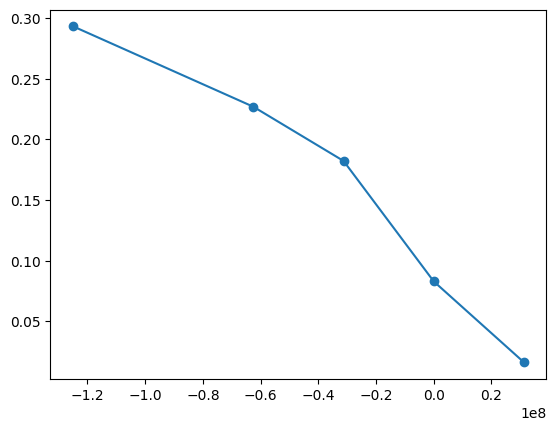

In [72]:
plt.plot(delta_g_all_int, hamming_average_all_norm,'o-')


### Classical

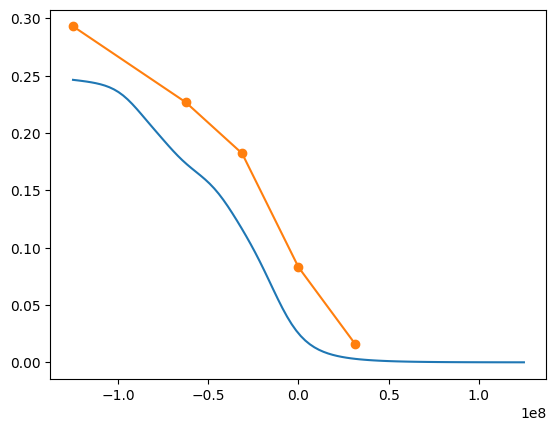

In [73]:
with open("data/Monte_carlo/av_conc_1000000_4um.json", "r") as f:
    data = json.load(f)

# Plot each temperature's data
# plt.figure(figsize=(8, 6))

for T, values in data.items():
    x = np.array(values["Delta_mu"])*eV_to_rad_s
    y = np.array(values["avg_conc"])
   
    plt.plot(x, y,'-',label=f'B {float(T):.3e}')
plt.plot(delta_g_all_int, hamming_average_all_norm,'o-')

### 4.1 micrometer

In [74]:
folder = '/Users/brunocamino/Desktop/UCL/rydberg_atoms/qpu_data/4.1micrometers/'
datasets = []
delta_g_all = ['-125000000','-62500000','-12500','-1250','0','1250','62500000','125000000']
delta_g_all_int = [-int(x) for x in delta_g_all]

for delta_g in delta_g_all: 
    preseqs, postseqs = read_all_sequences_from_folder(os.path.join(folder, delta_g))
    datasets.append((preseqs, postseqs, f"Δg = {delta_g}"))

In [75]:
hamming_average_all = []
num_sites = 78
for idx, (preseqs, postseqs, label) in enumerate(datasets):


    # Compute Hamming distances
    len_hamming, hamming_average, hamming_std, hamming_max, \
    hamming_min, hamming_unique, unique_index = get_hamming(preseqs, postseqs)
    
    hamming_average_all.append(hamming_average)

hamming_average_all = np.array(hamming_average_all)
hamming_average_all_norm = hamming_average_all/num_sites

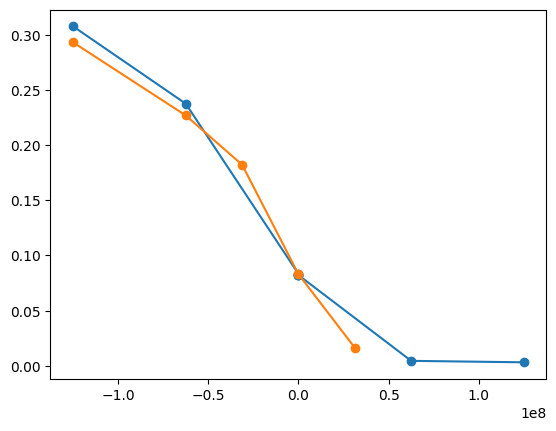

In [76]:
plt.plot(delta_g_all_int, hamming_average_all_norm,'o-')
plt.plot(delta_g_all_int_4, hamming_average_all_norm_4,'o-')

### Classical

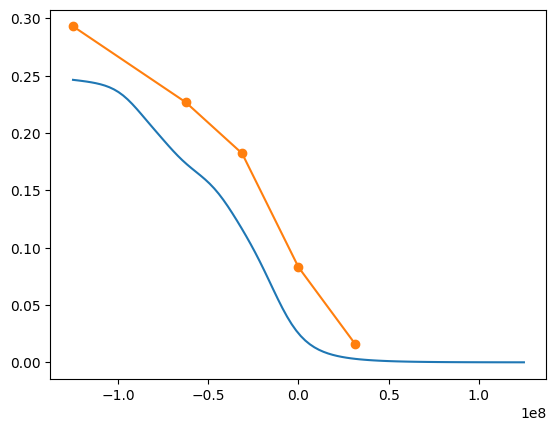

In [ ]:
with open("data/Monte_carlo/av_conc_1000000_4um.json", "r") as f:
    data = json.load(f)

# Plot each temperature's data
# plt.figure(figsize=(8, 6))

for T, values in data.items():
    x = np.array(values["Delta_mu"])*eV_to_rad_s
    y = np.array(values["avg_conc"])
   
    plt.plot(x, y,'-',label=f'B {float(T):.3e}')
plt.plot(delta_g_all_int, hamming_average_all_norm,'o-')

## Convergence num_samples

In [ ]:
import json
import matplotlib.pyplot as plt

# Load results
with open("scripts/monte_carlo/num_samples/av_conc_vs_size.json", "r") as f:
    results = json.load(f)

# Plot
plt.figure(figsize=(10, 6))

for size, data in results.items():
    Delta_mu = data["Delta_mu"]
    avg_conc = data["avg_conc"]
    plt.plot(Delta_mu, avg_conc, label=f"N = {size}")

plt.xlabel("Δμ (eV)")
plt.ylabel("Average concentration")
plt.title("Convergence of avg concentration vs Δμ at T = 1e-6")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()